<a href="https://colab.research.google.com/github/Freddsle/ML_Blindness_Detection/blob/main/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> collab

In [50]:
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import random
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score

from PIL import Image

In [51]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

In [52]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Data

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:
- **0 - No DR**
- **1 - Mild**
- **2 - Moderate**
- **3 - Severe**
- **4 - Proliferative DR**

Images may contain artifacts, be out of focus, underexposed, or overexposed. 

- train.csv - the training labels
- test.csv - the test set (you must predict the diagnosis value for these variables)
- sample_submission.csv - a sample submission file in the correct format
- train.zip - the training set images
- test.zip - the public test set images

Dowload directly from kaggle (kaggle.json is needed for API - put it in `/content/`):

In [23]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

clear_output()

In [24]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [02:01<00:00, 61.1MB/s]
100% 9.51G/9.51G [02:01<00:00, 84.0MB/s]


In [25]:
! unzip aptos2019-blindness-detection
! rm aptos2019-blindness-detection.zip

clear_output()

# EDA

In [53]:
train_dir = os.path.join('.','train_images/')
df = pd.read_csv(os.path.join('.', 'train.csv'))

df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

df.head(10)

,diagnosis,path
0,2,./train_images/a01c590c444f.png
1,1,./train_images/22098b1fe461.png
2,0,./train_images/83a63c4a3e4a.png
3,4,./train_images/e821c1b6417a.png
4,0,./train_images/bd06028eb7dd.png
5,3,./train_images/6089fa333013.png
6,2,./train_images/9b418ce42c13.png
7,0,./train_images/c6a8f8f998a2.png
8,0,./train_images/b72f59b85f7c.png
9,1,./train_images/8bbd7835e9aa.png


In [ ]:
len_df = len(df)
print(f"There are {len_df} images in df.")

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels.

In [ ]:
df.diagnosis.value_counts() 

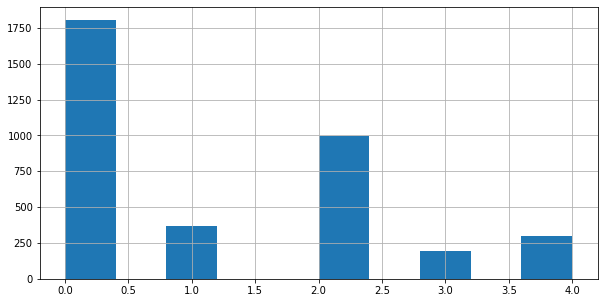

In [ ]:
df['diagnosis'].hist(figsize = (10, 5))

Example image:

In [ ]:
im = Image.open(df['path'][1])
width, height = im.size
print(width,height) 
im.show()

2896 1944


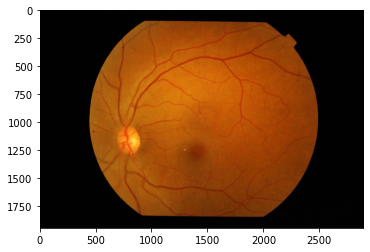

In [ ]:
plt.imshow(np.asarray(im))

Is the number of chanels always 3? - yes

In [ ]:
# long run
for i in range(len_df):
    img = np.array(Image.open(df['path'][i])).shape
    
    if img[2] != 3:
      print(img)

# Load data

In [54]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split

In [55]:
RESCALE_SIZE = 224, 224
BATCH_SIZE = 64

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 15, 10

In [56]:
train_df, val_df = train_test_split(df, test_size=0.25,
                                    stratify=df.diagnosis)

train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [57]:
class BlindDataset(Dataset):
    def __init__(self, df, mode="train") -> None:
        super().__init__()

        self.df = df
        self.len_ = len(self.df.path)
        self.mode = mode

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.3056, 0.1627, 0.0532], 
                                     [0.2992, 0.1616, 0.0764]),
            ])
        
        else:
            transform = transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.3056, 0.1627, 0.0532], 
                                     [0.2992, 0.1616, 0.0764]),
            ])

        tensor_image = self.load_sample(self.df.path[index])
        tensor_image = transform(tensor_image)

        if self.mode != 'test':
            return tensor_image, self.df.diagnosis[index]
        else:
            return tensor_image
        

In [58]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

class_numbers = Counter(train_df.diagnosis)
samples_weight = torch.tensor([1 / class_numbers[i] for i in train_df.diagnosis])

In [59]:
trainset = BlindDataset(train_df)
valset = BlindDataset(val_df, mode="val")

sampler = WeightedRandomSampler(samples_weight.type("torch.DoubleTensor"), len(samples_weight))

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         #sampler=sampler,
                         shuffle=True, 
                         )
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

Расчет параметров для transforms.Normalize:

In [ ]:
from tqdm import tqdm

psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
for inputs, y in tqdm(trainloader):
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

# pixel count
count = len(df) * RESCALE_SIZE[0] * RESCALE_SIZE[0]

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

# 224x224:
#mean: tensor([0.3056, 0.1627, 0.0532])
#std:  tensor([0.2992, 0.1616, 0.0764])

# 728x728: 
#mean: tensor([0.3056, 0.1627, 0.0532])
#std:  tensor([0.2997, 0.1620, 0.0768])

# 450x450:
# mean: tensor([0.3057, 0.1628, 0.0533])
# std:  tensor([0.2996, 0.1619, 0.0766])

### Класс для тренировки и валидации

In [60]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,
                 validate=True, scheduler=None,
                 verbose=2):
      
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)

                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [61]:
def predict(model, loader, mod='val'):
    model.eval()
    predictions = []
    targ = []

    with torch.no_grad():
        if mod == 'val':
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)              
                out = model(inputs)
                out = nn.functional.softmax(out, dim=-1)
                _, preds = torch.max(out.data, 1)
                predictions += list(preds)
                targ += list(targets)
            return predictions, targ

        else:
            for i, inputs in enumerate(loader):
                inputs = inputs.to(DEVICE)
                out = model(inputs)
                out = nn.functional.softmax(out, dim=-1)
                _, preds = torch.max(out.data, 1)
                predictions += list(preds)
            return predictions


def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

# vgg19

In [18]:
import torchvision
from torch import nn

In [19]:
model = torchvision.models.vgg19_bn(pretrained=True)

In [20]:
N_CLASSES = 5
num_features = 4096
model.classifier[6] = nn.Linear(num_features, N_CLASSES)

model = model.to(DEVICE)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [22]:
trainer = Trainer(model, 8, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score,
                  scheduler=scheduler)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 8: Train loss = 1.0442546162494393, validation loss = 0.9987798968950907 
                                         Train metric = 0.23306627822286963, validation metric = 0.2445414847161572

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 8: Train loss = 0.8517160970111226, validation loss = 0.810299030939738 
                                         Train metric = 0.23634377276037874, validation metric = 0.25436681222707425

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 8: Train loss = 0.8677684692449348, validation loss = 0.8745779494444529 
                                         Train metric = 0.21704297159504735, validation metric = 0.212882096069869

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 8: Train loss = 0.8281515587207883, validation loss = 1.3735697905222575 
                                         Train met

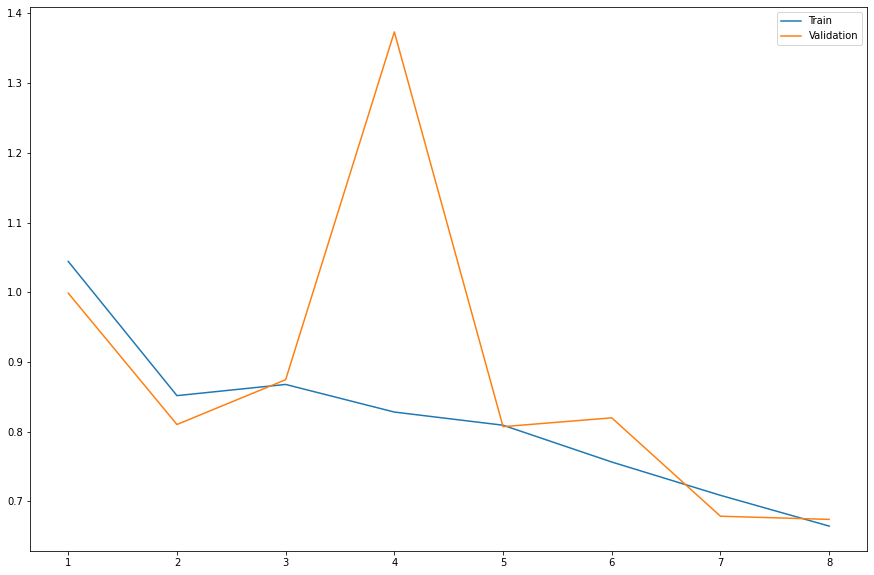

In [23]:
sns.lineplot(y=trainer.train_losses, x=range(1, 9), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 9), label="Validation")

plt.show()

In [24]:
# save model
torch.save(model.state_dict(), '/content/drive/MyDrive/models/vgg19_fin.txt')

In [25]:
from functools import partial

f1_macro = partial(f1_score, average="macro")
f1_micro = partial(f1_score, average="micro")

In [26]:
calculate_metric(model, valloader)
#224x224 batch 64 - .8024017467248908
# тоже, только без шаффла 0.7150655021834061

0.75764192139738

In [ ]:
calculate_metric(model, valloader, f1_macro)
#224x224 batch 64 - .5190434141012477
# тоже, только без шаффла 0.5748944091876842

In [28]:
calculate_metric(model, valloader, f1_micro)
#224x224 batch 64 - 0.8024017467248908
# тоже, только без шаффла 

0.75764192139738

In [24]:
del trainer
del model

torch.cuda.empty_cache()
torch.cuda.synchronize()

# DenseNet169

In [70]:
model = torchvision.models.densenet169(pretrained=True)

In [71]:
N_CLASSES = 5
num_features = 1664
model.classifier = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

trainer = Trainer(model, 15, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score,
                  scheduler=scheduler)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 15: Train loss = 0.7173430531523949, validation loss = 0.6675484855969747 
                                         Train metric = 0.43335761107064824, validation metric = 0.37882096069869

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 15: Train loss = 0.5251290791256483, validation loss = 0.686632490158081 
                                         Train metric = 0.48943918426802624, validation metric = 0.5589519650655022

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 15: Train loss = 0.5019472040409265, validation loss = 0.5110388199488322 
                                         Train metric = 0.5728332119446468, validation metric = 0.5054585152838428

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 15: Train loss = 0.47127643158269483, validation loss = 0.48858435948689777 
                                         Train 

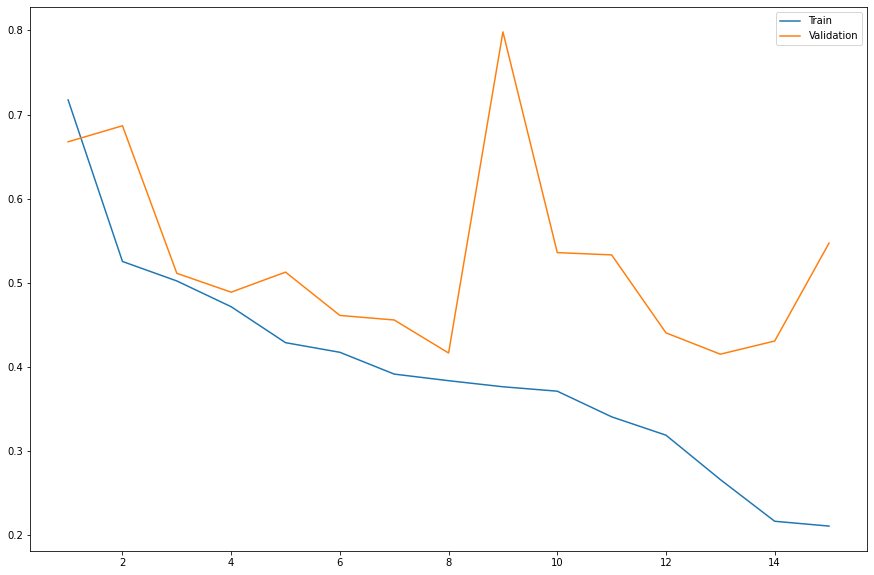

In [73]:
sns.lineplot(y=trainer.train_losses, x=range(1, 16), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 16), label="Validation")

plt.show()

In [74]:
calculate_metric(model, valloader)
#224x224 batch 64 - 0.8144104803493449
# тоже, только без шаффла 0.7641921397379913

0.8198689956331878

In [75]:
calculate_metric(model, valloader, f1_macro)
#224x224 batch 64 - 0.6560790065258206
# тоже, только без шаффла 0.6223088864604981

0.6860002819204131

In [76]:
calculate_metric(model, valloader, f1_micro)
#224x224 batch 64 - 0.8144104803493449
# тоже, только без шаффла 0.7641921397379913

0.8198689956331879

In [77]:
# save model
torch.save(model.state_dict(), '/content/drive/MyDrive/models/densnet169.txt')

In [78]:
del trainer
del model

torch.cuda.empty_cache()
torch.cuda.synchronize()

# DenseNet201

In [31]:
model = torchvision.models.densenet201(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


  0%|          | 0.00/77.4M [00:00<?, ?B/s]

In [32]:
N_CLASSES = 5
num_features = 1920
model.classifier = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score,
                  scheduler=scheduler)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 10: Train loss = 0.6988822831663974, validation loss = 0.5834464649359385 
                                         Train metric = 0.48871085214857973, validation metric = 0.5622270742358079

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 10: Train loss = 0.5270664428555688, validation loss = 0.4848905821641286 
                                         Train metric = 0.5844865258557902, validation metric = 0.6353711790393013

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 10: Train loss = 0.48495238257008927, validation loss = 0.5370422601699829 
                                         Train metric = 0.6383831026948289, validation metric = 0.6222707423580786

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 10: Train loss = 0.4548941012038741, validation loss = 0.43787068327267964 
                                         Trai

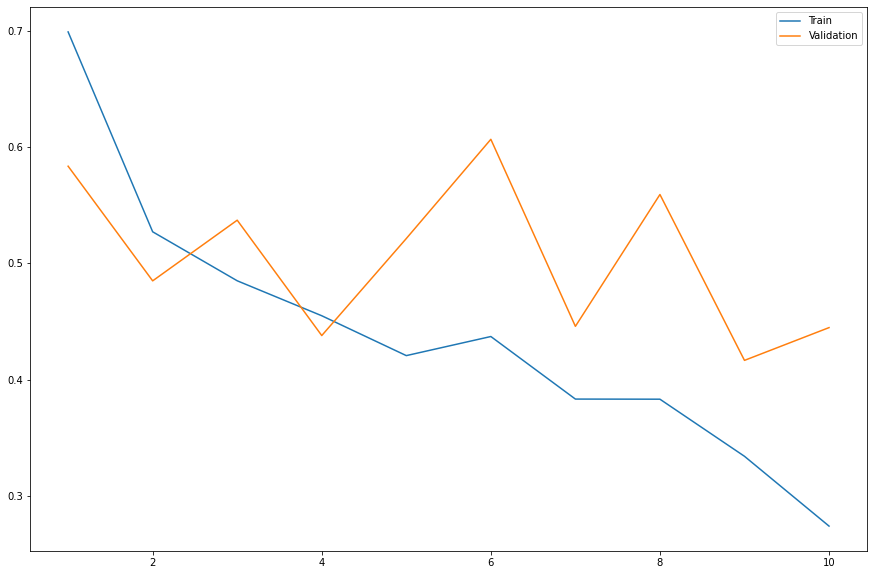

In [34]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [35]:
calculate_metric(model, valloader)

0.8351528384279476

In [36]:
calculate_metric(model, valloader, f1_macro)

0.669687295688473

In [37]:
calculate_metric(model, valloader, f1_micro)

0.8351528384279476

In [38]:
torch.save(model.state_dict(), '/content/drive/MyDrive/models/densnet201.txt')

In [39]:
del trainer
del model

torch.cuda.empty_cache()
torch.cuda.synchronize()

# RESNET34

In [62]:
model = torchvision.models.resnet34(pretrained=True)

In [63]:
N_CLASSES = 5
num_features = 512
model.fc = nn.Linear(num_features, N_CLASSES)
model = model.to(DEVICE)

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, 
                  DEVICE, accuracy_score,
                  scheduler=scheduler)
trainer.fit()

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 1 out of 10: Train loss = 0.8196856123070384, validation loss = 0.9808936595916748 
                                         Train metric = 0.28368536052439913, validation metric = 0.4017467248908297

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 2 out of 10: Train loss = 0.5787979170333507, validation loss = 0.6860848307609558 
                                         Train metric = 0.44865258557902404, validation metric = 0.3962882096069869

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 3 out of 10: Train loss = 0.5376818117707275, validation loss = 0.5510422090689341 
                                         Train metric = 0.44100509832483614, validation metric = 0.4661572052401747

Training: batch 43 out of 43
Validation: batch 15 out of 15

Epoch 4 out of 10: Train loss = 0.48446223763532414, validation loss = 0.7846026500066121 
                                         Tra

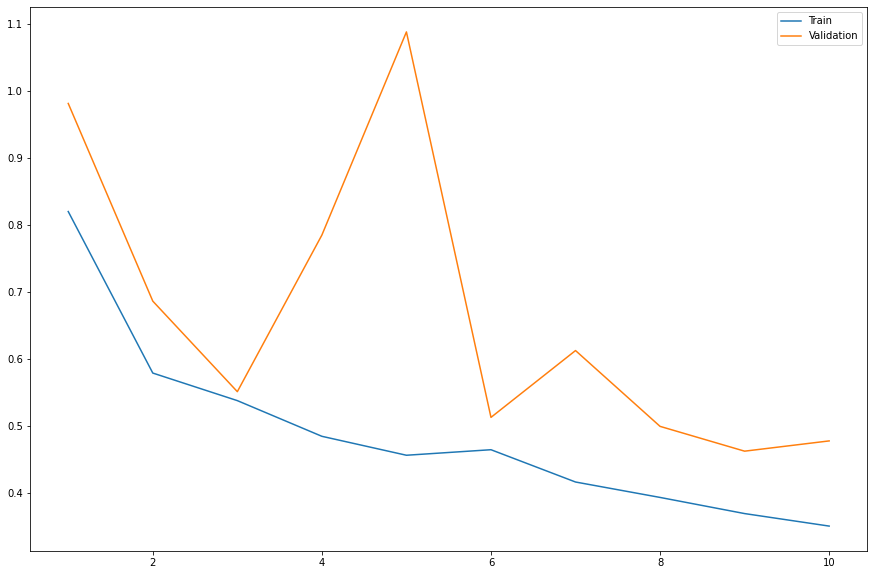

In [65]:
sns.lineplot(y=trainer.train_losses, x=range(1, 11), label="Train")
sns.lineplot(y=trainer.valid_losses, x=range(1, 11), label="Validation")

plt.show()

In [66]:
calculate_metric(model, valloader)

0.8165938864628821

In [67]:
calculate_metric(model, valloader, f1_macro)

0.6192900554618977

In [68]:
calculate_metric(model, valloader, f1_micro)

0.8165938864628821

In [69]:
# save model
torch.save(model.state_dict(), '/content/drive/MyDrive/models/resnet34.txt')

In [79]:
del trainer

torch.cuda.empty_cache()
torch.cuda.synchronize()

NameError: ignored

# Предсказание

In [94]:
test_dir = os.path.join('.','test_images/')
df_t = pd.read_csv(os.path.join('.', 'test.csv'))

df_t['path'] = df_t['id_code'].map(lambda x: os.path.join(test_dir,'{}.png'.format(x)))
df_t = df_t.drop(columns=['id_code'])
df_t = df_t.sample(frac=1).reset_index(drop=True) #shuffle dataframe

df_t.head(10)

,path
0,./test_images/c59e7e8eeeb5.png
1,./test_images/3bab7d408b23.png
2,./test_images/43c7740f646a.png
3,./test_images/e002ce3cfe09.png
4,./test_images/020f6983114d.png
5,./test_images/447d8e8f446d.png
6,./test_images/8f874a9724df.png
7,./test_images/69d21c5c7dce.png
8,./test_images/a7699068be9a.png
9,./test_images/b501a5bdd0cc.png


In [100]:
testset = BlindDataset(df_t, mode="test")
teslloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [102]:
results = predict(model, teslloader, mod='test')

In [106]:
new_list = []
for i in results:
  new_list.append(i.item())

In [108]:
df_test = pd.read_csv(os.path.join('.', 'test.csv'))
df_test['diagnosis'] = new_list

In [109]:
df_test.to_csv("submission.csv", index=False)